In [1]:
from utils import sars2_genome_info, get_parent, add_syn_mut_attribute, add_mut_at_node_attr, add_changes_from_ref_attr
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import json
import string
import requests

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Figure 2: Ratio of nonsynonymous to synonymous divergence is highest S1

##### The nonsynonymous and synonymous divergence in different regions of the genome is calculated over time. The ratio of nonsynonymous to synonymous divergence is then plotted.

#### This notebook completes the analysis Figure 2. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-08-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that lists all mutations that have occurred between the root and node

In [5]:
tree = add_changes_from_ref_attr(tree)

Generate temporal windows, starting at the date of of the root and extending for a length of time specified by "window_len"

In [6]:
first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades():
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
def make_time_windows(window_len):
    time_windows = np.arange(first_timepoint, last_timepoint, window_len).tolist()
    time_windows += [last_timepoint]
    return time_windows

For each time window, compute dN/dS for each isolate within the window. For each isolate, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [7]:
def find_divergence_in_window(window_len=0.2):
    time_windows = make_time_windows(window_len)
    
#     window_divergence_info = []
    window_dnds_info = []
    
    # look at divergence within time window
    for x in range(1,len(time_windows)):
        start_date = time_windows[x-1]
        end_date = time_windows[x]
        
        s1_div_in_window = []
        s1_syn_div_in_window = []
        rdrp_div_in_window = []
        rdrp_syn_div_in_window = []

        for node in tree.find_clades():
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                if len(node.get_terminals())>=3:
                                 

                    s1_div = len(node.node_attrs["changes_from_ref"]['s1_non'])/(gene_lengths_aa['S1']*3*(438/576))
                    
                    #assign a false count to avoid dividing by zero
                    if len(node.node_attrs["changes_from_ref"]['s1_syn']) == 0:
                        s1_syn_div = 1/(gene_lengths_aa['S1']*3*(138/576))
                    else:
                        s1_syn_div = (len(node.node_attrs["changes_from_ref"]['s1_syn'])+1)/(gene_lengths_aa['S1']*3*(138/576))
                    
                    
                    s1_n_over_s = s1_div/s1_syn_div

                    

                    rdrp_div = len(node.node_attrs["changes_from_ref"]['rdrp_non'])/(gene_lengths_aa['RdRp']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['rdrp_syn']) == 0:
                        rdrp_syn_div = 1/(gene_lengths_aa['RdRp']*3*(138/576))
                    else:
                        rdrp_syn_div = (len(node.node_attrs["changes_from_ref"]['rdrp_syn'])+1)/(gene_lengths_aa['RdRp']*3*(138/576))
                        
                    rdrp_n_over_s = rdrp_div/rdrp_syn_div
                    

                    e_div = len(node.node_attrs["changes_from_ref"]['e_non'])/(gene_lengths_aa['E']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['e_syn']) == 0:
                        e_syn_div = 1/(gene_lengths_aa['E']*3*(138/576))
                    else:
                        e_syn_div = (len(node.node_attrs["changes_from_ref"]['e_syn'])+1)/(gene_lengths_aa['E']*3*(138/576))
                        
                    e_n_over_s = e_div/e_syn_div
                    

                    
                    
                    n_div = len(node.node_attrs["changes_from_ref"]['n_non'])/(gene_lengths_aa['N']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['n_syn']) == 0:
                        n_syn_div = 1/(gene_lengths_aa['N']*3*(138/576))
                    else:
                        n_syn_div = (len(node.node_attrs["changes_from_ref"]['n_syn'])+1)/(gene_lengths_aa['N']*3*(138/576))
                        
                    n_n_over_s = n_div/n_syn_div
                    
                    
                    
                    m_div = len(node.node_attrs["changes_from_ref"]['m_non'])/(gene_lengths_aa['M']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['m_syn']) == 0:
                        m_syn_div = 1/(gene_lengths_aa['M']*3*(138/576))
                    else:
                        m_syn_div = (len(node.node_attrs["changes_from_ref"]['m_syn'])+1)/(gene_lengths_aa['M']*3*(138/576))
                        
                    m_n_over_s = m_div/m_syn_div
                    
    

                    s2_div = len(node.node_attrs["changes_from_ref"]['s2_non'])/(gene_lengths_aa['S2']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['s2_syn']) == 0:
                        s2_syn_div = 1/(gene_lengths_aa['S2']*3*(138/576))
                    else:
                        s2_syn_div = (len(node.node_attrs["changes_from_ref"]['s2_syn'])+1)/(gene_lengths_aa['S2']*3*(138/576))
                        
                    s2_n_over_s = s2_div/s2_syn_div
                    
                        
                        
                        
                        
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s1_n_over_s, 'location': 'S1'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':rdrp_n_over_s, 'location': 'RdRp'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':e_n_over_s, 'location': 'E'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':n_n_over_s, 'location': 'N'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':m_n_over_s, 'location': 'M'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s2_n_over_s, 'location': 'S2'})



        
                

    window_dnds_df = pd.DataFrame(window_dnds_info)
        

    return window_dnds_df
        

Generate a dataframe containing dN/dS information for each gene and temporal window

In [8]:
window_dnds = find_divergence_in_window()

Find the overall mean dn/ds in S1 and the dn/ds in 2021

In [9]:
mean_overall = window_dnds[window_dnds['location']=='S1']['dn/ds'].mean()
print(f'Overall mean dn/ds in S1: {mean_overall}')

mean_2021 = window_dnds[(window_dnds['location']=='S1')& (window_dnds['window_start']>=2020.9)]['dn/ds'].mean()
print(f'2021 mean dn/ds in S1: {mean_2021}')

Overall mean dn/ds in S1: 0.8842348205023799
2021 mean dn/ds in S1: 1.9151798344482673


Plot dN/dS over time for each gene

This code generates Figure 2.

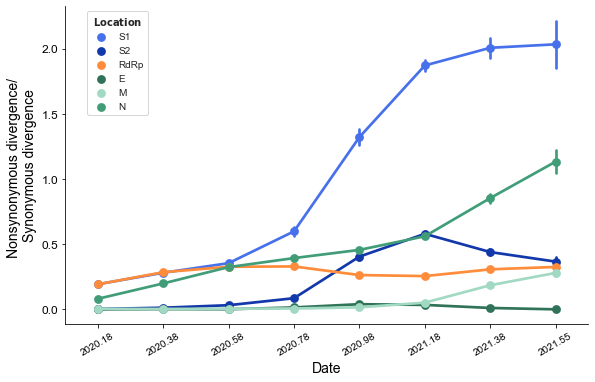

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
plt.tight_layout()
sns.set_style("white")
cmap = {'RdRp':"#ff8c3a", 'S1':"#4770eb", 'E': '#307358', 'N': '#419D78', 'M': '#a2d9c3', 'S2': '#1238aa'}

sns.pointplot(x='window_end', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds, hue_order=['S1', 'S2', 'RdRp', 'E', 'M', 'N'],
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Nonsynonymous divergence/ \nSynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=30)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.1, 1.0), 
                 title = r'$\bf{Location}$')